In [1]:
import pandas

size_log = pandas.read_pickle("5-generated-mdps/success.pkl.gz")
aborts = pandas.read_pickle("5-generated-mdps/fail.pkl.gz")

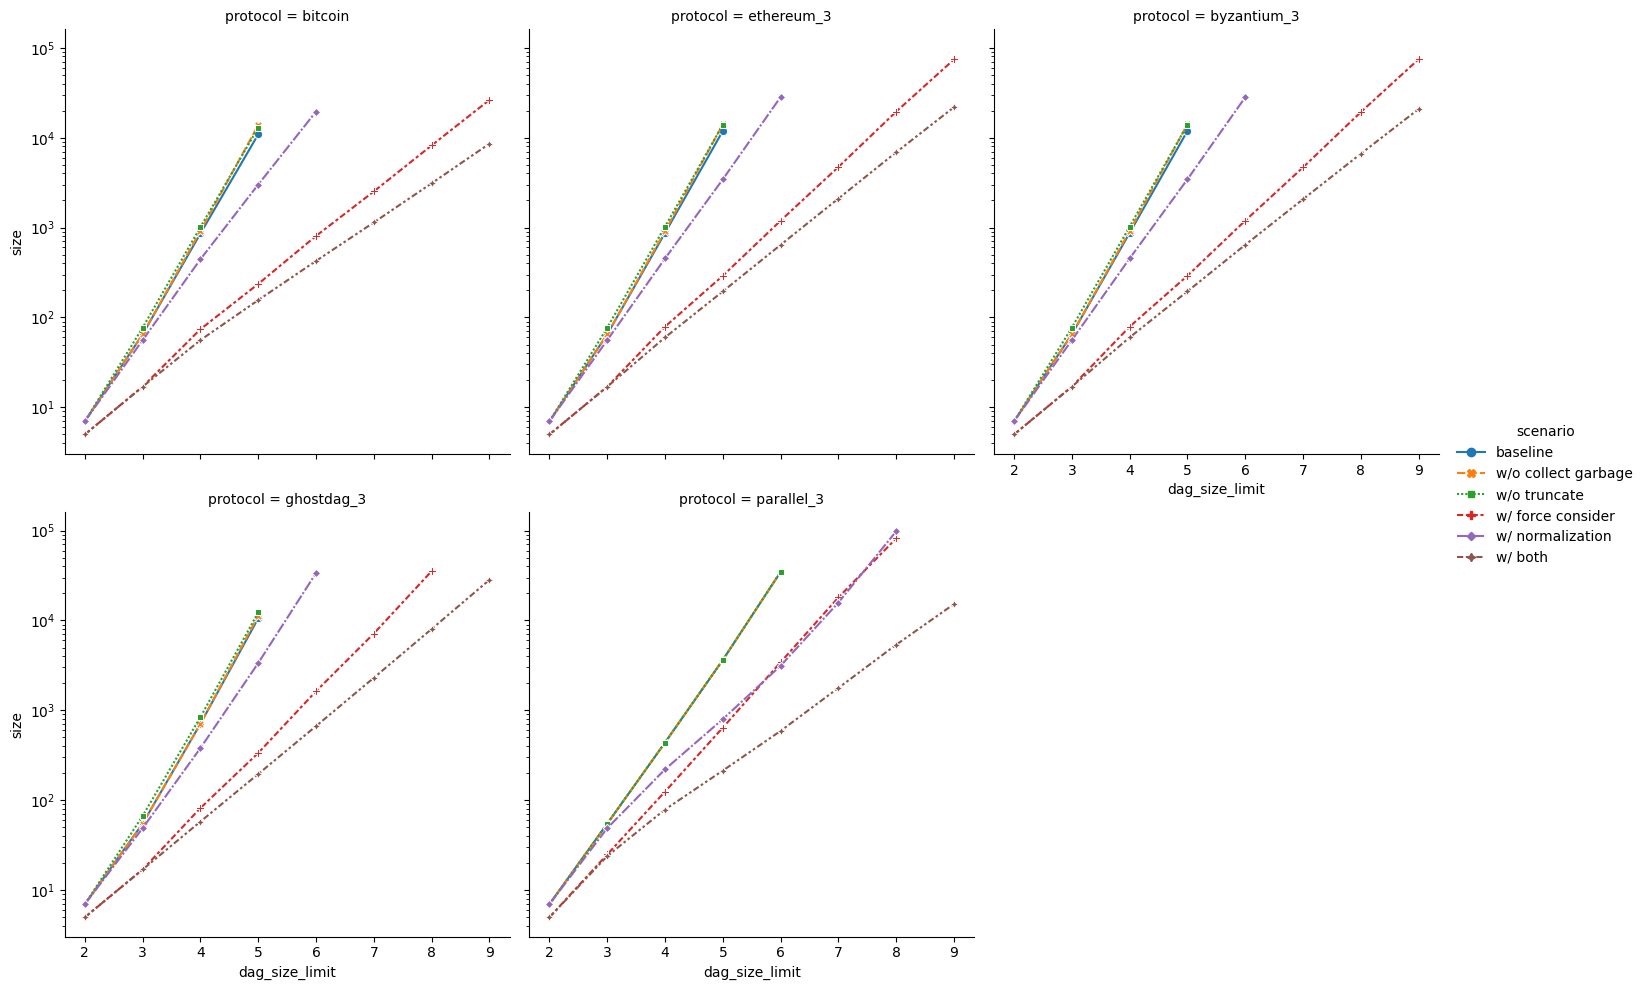

In [2]:
import seaborn

seaborn.relplot(
    data=size_log.query("dag_size_limit < 10"),
    kind="line",
    x="dag_size_limit",
    y="size",
    hue="scenario",
    style="scenario",
    markers=True,
    col="protocol",
    col_wrap=3,
).set(yscale="log")

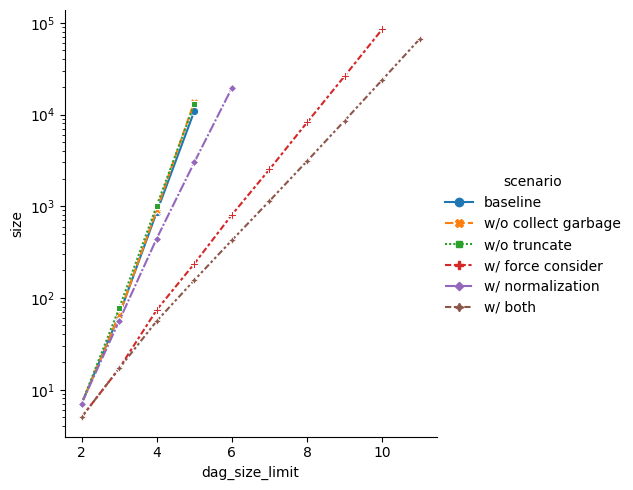

In [3]:
seaborn.relplot(
    data=size_log.query("protocol == 'bitcoin' and dag_size_limit < 13"),
    kind="line",
    x="dag_size_limit",
    y="size",
    hue="scenario",
    style="scenario",
    markers=True,
).set(yscale="log")

In [4]:
scenario_labels = {
    "reference": "reference-fc16",
    "reference-v0": "drop",
    "baseline": "baseline",
    "w/o collect garbage": "baseline-gc",
    "w/o truncate": "baseline-tc",
    "w/ force consider": "baseline+fc",
    "w/ normalization": "baseline+n",
    "w/ both": "baseline+fc+n",
}

cutoff = max(size_log.query("scenario != 'reference'").dag_size_limit) + 1

btc_size = (
    size_log.assign(scenario=[scenario_labels[x] for x in size_log.scenario])
    .query("scenario != 'drop'")
    .query("protocol == 'bitcoin'")
    .query(f"dag_size_limit <= {cutoff}")
    .pivot(index="dag_size_limit", columns="scenario", values="size")
)

btc_size.to_csv("5-state-space-exploration-viz-for-paper-btc-size.csv")
btc_size

scenario,baseline,baseline+fc,baseline+fc+n,baseline+n,baseline-gc,baseline-tc
dag_size_limit,,,,,,
2,7.0,5.0,5.0,7.0,7.0,7.0
3,65.0,17.0,17.0,56.0,65.0,77.0
4,860.0,74.0,56.0,444.0,916.0,1012.0
5,10870.0,236.0,156.0,3006.0,13778.0,12892.0
6,NaN,806.0,425.0,19474.0,NaN,NaN
7,NaN,2519.0,1139.0,NaN,NaN,NaN
8,NaN,8188.0,3103.0,NaN,NaN,NaN
9,NaN,26225.0,8554.0,NaN,NaN,NaN
10,NaN,85078.0,23826.0,NaN,NaN,NaN


In [5]:
# how should we report on the other protocols?
# column a: show max depth explored in table for fully optimized exploration only; calculate blow up factor and add as columns


def tabulate_deepest(d):
    return d.iloc[d.groupby(["scenario", "protocol"]).dag_size_limit.idxmax()]


biggest = (
    tabulate_deepest(size_log)
    .reset_index(drop=True)
    .query("scenario != 'w/o collect garbage'")
    .query("scenario != 'reference-v0'")
)

biggest.to_pickle("5-generated-mdps/biggest.pkl.gz")

biggest

,scenario,model,protocol,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,dag_size_limit,size,time_spent,rss,mdp
0,baseline,generic_1,bitcoin,False,False,True,True,False,5,10870,5.265134,0.251690,1215d126
1,baseline,generic_1,byzantium_3,False,False,True,True,False,5,11876,6.450769,0.259777,34b2c2bf
2,baseline,generic_1,ethereum_3,False,False,True,True,False,5,11876,6.134111,0.264961,347d47e3
3,baseline,generic_1,ghostdag_3,False,False,True,True,False,5,10573,6.447067,0.246181,5ae2d92b
4,baseline,generic_1,parallel_3,False,False,True,True,False,6,34664,22.241043,0.467800,fed621fe
5,w/ both,generic_1,bitcoin,True,True,True,True,False,11,66749,88.749878,0.922276,70055a08
6,w/ both,generic_1,byzantium_3,True,True,True,True,False,10,66065,79.414868,0.866085,4329a868
7,w/ both,generic_1,ethereum_3,True,True,True,True,False,10,68558,76.310316,0.891964,37d88a78
8,w/ both,generic_1,ghostdag_3,True,True,True,True,False,9,28264,44.222923,0.448185,6eb2955b
9,w/ both,generic_1,parallel_3,True,True,True,True,False,11,96136,137.866622,1.273708,5c6aebbd


In [6]:
# how should we report on the other protocols?
# column b: fix depth in table

fixed_cutoff = min(biggest.dag_size_limit)
fixed = (
    size_log.query("scenario != 'w/o collect garbage'")
    .query("scenario != 'reference-v0'")
    .query(f"dag_size_limit == {fixed_cutoff}")
    .reset_index(drop=True)
)
fixed.to_pickle("5-generated-mdps/fixed.pkl.gz")
fixed

,scenario,model,protocol,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,dag_size_limit,size,time_spent,rss,mdp
0,baseline,generic_1,bitcoin,False,False,True,True,False,5,10870,5.265134,0.251690,1215d126
1,baseline,generic_1,ethereum_3,False,False,True,True,False,5,11876,6.134111,0.264961,347d47e3
2,baseline,generic_1,byzantium_3,False,False,True,True,False,5,11876,6.450769,0.259777,34b2c2bf
3,baseline,generic_1,ghostdag_3,False,False,True,True,False,5,10573,6.447067,0.246181,5ae2d92b
4,baseline,generic_1,parallel_3,False,False,True,True,False,5,3637,1.929493,0.216213,3784d81e
5,w/o truncate,generic_1,bitcoin,False,False,False,True,False,5,12892,5.592142,0.278366,4b9c96f9
6,w/o truncate,generic_1,ethereum_3,False,False,False,True,False,5,13922,6.631893,0.285465,344c40b7
7,w/o truncate,generic_1,byzantium_3,False,False,False,True,False,5,13922,7.077445,0.285618,2638371e
8,w/o truncate,generic_1,ghostdag_3,False,False,False,True,False,5,12291,5.958618,0.268909,d7e36bfa
9,w/o truncate,generic_1,parallel_3,False,False,False,True,False,5,3637,1.837963,0.248631,10a26e96


In [7]:
combined = pandas.DataFrame(
    dict(
        max_dag_size_limit=biggest.set_index(["scenario", "protocol"]).dag_size_limit,
        size_at_fixed_dag_size=fixed.set_index(["scenario", "protocol"])["size"],
    )
).reset_index()
combined

,scenario,protocol,max_dag_size_limit,size_at_fixed_dag_size
0,baseline,bitcoin,5,10870
1,baseline,byzantium_3,5,11876
2,baseline,ethereum_3,5,11876
3,baseline,ghostdag_3,5,10573
4,baseline,parallel_3,6,3637
5,w/ both,bitcoin,11,156
6,w/ both,byzantium_3,10,195
7,w/ both,ethereum_3,10,195
8,w/ both,ghostdag_3,9,196
9,w/ both,parallel_3,11,214


In [8]:
fixed_cutoff

5

In [9]:
combined.query('scenario != "reference"').set_index(["scenario", "protocol"]).unstack(
    level=0
).stack(level=0, future_stack=True).unstack(level=1)

scenario              baseline                                   w/ both  \
            max_dag_size_limit size_at_fixed_dag_size max_dag_size_limit   
protocol                                                                   
bitcoin                      5                  10870                 11   
byzantium_3                  5                  11876                 10   
ethereum_3                   5                  11876                 10   
ghostdag_3                   5                  10573                  9   
parallel_3                   6                   3637                 11   

scenario                            w/ force consider                         \
            size_at_fixed_dag_size max_dag_size_limit size_at_fixed_dag_size   
protocol                                                                       
bitcoin                        156                 10                    236   
byzantium_3                    195                  9                    291   
ethereum_3                     195                  9                    291   
ghostdag_3                     196                  8                    336   
parallel_3                     214                  8                    643   

scenario      w/ normalization                              w/o truncate  \
            max_dag_size_limit size_at_fixed_dag_size max_dag_size_limit   
protocol                                                                   
bitcoin                      6                   3006                  5   
byzantium_3                  6                   3438                  5   
ethereum_3                   6                   3438                  5   
ghostdag_3                   6                   3360                  5   
parallel_3                   8                    800                  6   

scenario                            
            size_at_fixed_dag_size  
protocol                            
bitcoin                      12892  
byzantium_3                  13922  
ethereum_3                   13922  
ghostdag_3                   12291  
parallel_3                    3637